SUMBER: https://github.com/Wonuabimbola/movie-genre-prediction/blob/main/predict_movie_genre_from_plot.ipynb

## Libraries & Datasets

In [2]:
# %pip install spacy
# import spacy.cli
# spacy.cli.download("en_core_web_lg")

# %pip install wordcloud
# %pip install mlxtend

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings
import seaborn as sns
# from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
warnings.filterwarnings('ignore')
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.text import FreqDistVisualizer
from mlxtend.feature_selection import ColumnSelector
import spacy
import pickle


In [4]:
movies = pd.read_csv('dataset/IMDB_four_genre_larger_plot_description.csv')

In [5]:
movies.head(5)

,movie_id,description,genre
0,tt12783454,Elle Evans (Joey King) has finally completed h...,romance
1,tt1798632,A young girl tries to understand how she myste...,horror
2,tt9214832,"In 1800s England, a well meaning but selfish y...",comedy
3,tt8522006,Abby Holland (Kristen Stewart) and Harper Cald...,romance
4,tt21249656,Olga and Maks are 15 years apart. She is a suc...,romance


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movie_id     1000 non-null   object
 1   description  1000 non-null   object
 2   genre        1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


In [7]:
movies.describe()

,movie_id,description,genre
count,1000,1000,1000
unique,1000,1000,4
top,tt12783454,Elle Evans (Joey King) has finally completed h...,romance
freq,1,1,250


In [8]:
movies.shape

(1000, 3)

## EDA

### Movies Distributions by Genre

Text(0, 0.5, 'Frequency of Occurence')

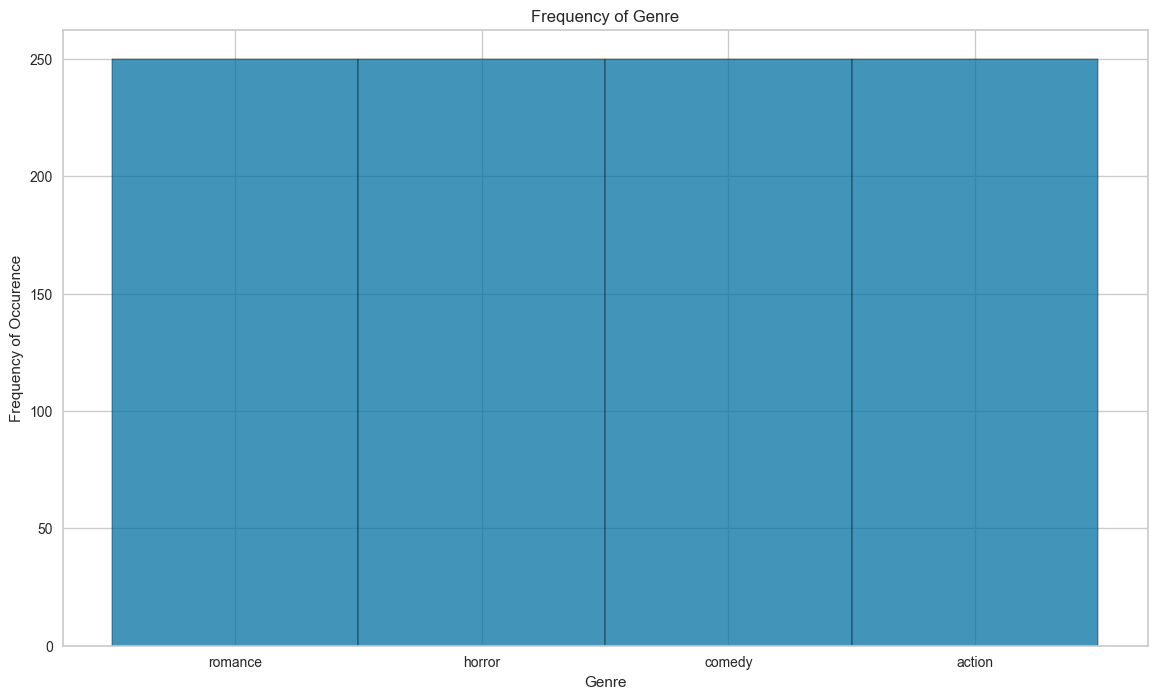

In [9]:
fig, ax = plt.subplots(figsize=(14,8))

sns.histplot(x = movies['genre'])
plt.title('Frequency of Genre')
plt.xlabel('Genre')
plt.ylabel('Frequency of Occurence')

Genre terdistribusi secara merata, yakni masing-masing 250 attributes.

### Buat label dari 1-4 untuk membedakan masing-masing genre

In [10]:
conditions = [movies['genre']=='romance', movies['genre']=='horror', movies['genre']=='comedy', movies['genre']=='action']
choices = [1,2,3,4]
movies['labels'] = np.select(conditions, choices, 0)

1.   romance
2.   horror
3.   comedy
4.   action



In [11]:
movies.sample(3)

,movie_id,description,genre,labels
213,tt6968614,"While fleeing from dangerous assailants, an as...",action,4
228,tt14849194,Nobody likes teacher Paul Hunham (Giamatti) --...,comedy,3
260,tt3465026,"After moving to Palm Springs, a young married ...",comedy,3


In [12]:
movies['labels'].value_counts()

labels
1    250
2    250
3    250
4    250
Name: count, dtype: int64

## Cleaning Plot for Analysis

In [13]:
movies['description'][5]

'A reformed hunter living in isolation on a wildlife sanctuary becomes involved in a deadly game of cat and mouse when he and the local Sheriff set out to track a vicious killer who may have kidnapped his daughter years ago. A reformed hunter now living secluded in a wildlife sanctuary after the disappearance of his teen daughter years ago saves a young girl from being killed by a serial killer but gets caught in a deadly catandmouse game. His path crosses with the town\'s sheriff who also seeks to bring the serial killer to justice after the discovery of the body of a teenaged girl. The movie opens with an dead person in brightly colored clothing floating down whitewater rapids.Elsewhere, we see a pair of hunters about to shoot a deer. Rayburn Swanson Nikolaj CosterWaldau stops them, and confiscates their weapons, and indicates that they\'re trespassing in a sanctuary. The hunters seem to know him, and their conversation indicates that Rayburn used to be a hunter himself. "People chan

### Total number of words in Description

In [14]:
def word_length(text):
    num_of_words = 0
    for row in text:
        words = [word for word in row.split(' ')]
        num_of_words += len(words)
    return num_of_words

raw_length = word_length(movies['description'])

### Total number UNIQUE in Description

In [15]:
def unique_word_length(text):
    unique_words = set()
    for row in text:
        words = [word for word in row.split(' ')]
        unique_words.update(words)
    return len(unique_words)

raw_unique_length = unique_word_length(movies['description'])

In [16]:
stopwords_list = stopwords.words('english')
punctuation_list = list(string.punctuation)
numeric_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
removed = stopwords_list + punctuation_list + numeric_list
removed += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells']
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = text.strip(' ')
    text = word_tokenize(text)
    text = ' '.join(text)
    text = nlp(text)
    text = [w.lemma_ for w in text]
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text

In [17]:
# Rechecking the description to test the function
new_movies = movies.copy(deep=True)

In [18]:
new_movies['description'] = new_movies['description'].map(lambda x : clean_text(x))
new_movies['description'][5]

'reform hunter live isolation wildlife sanctuary become involve deadly game cat mouse local sheriff set track vicious killer may kidnap daughter year ago reform hunter live secluded wildlife sanctuary disappearance teen daughter year ago save young girl kill serial killer get catch deadly catandmouse game path cross town sheriff also seek bring serial killer justice discovery body teenaged girl movie open dead person brightly colored clothing float whitewater rapid elsewhere see pair hunter shoot deer rayburn swanson nikolaj costerwaldau stop confiscate weapon indicate trespass sanctuary hunter seem know conversation indicate rayburn use hunter people change say one reply rayburn go home dog thor surveillance equipment monitor sanctuary meet sheriff alice gustafson annabelle wallis pick brother brooks hero fienne tiffin karl blackhawk zahn mcclarnon sheriff local tribal police find factory imply seedy location brooks look altercation refuse tell blackhawk happen factory alice drive bro

In [19]:
def word_length(text):
    num_of_words = 0
    for row in text:
        words = [word for word in row.split(' ')]
        num_of_words += len(words)
    return num_of_words

clean_length = word_length(new_movies['description'])

In [20]:
def unique_word_length(text):
    unique_words = set()
    for row in text:
        words = [word for word in row.split(' ')]
        unique_words.update(words)
    return len(unique_words)

clean_unique_length = unique_word_length(new_movies['description'])

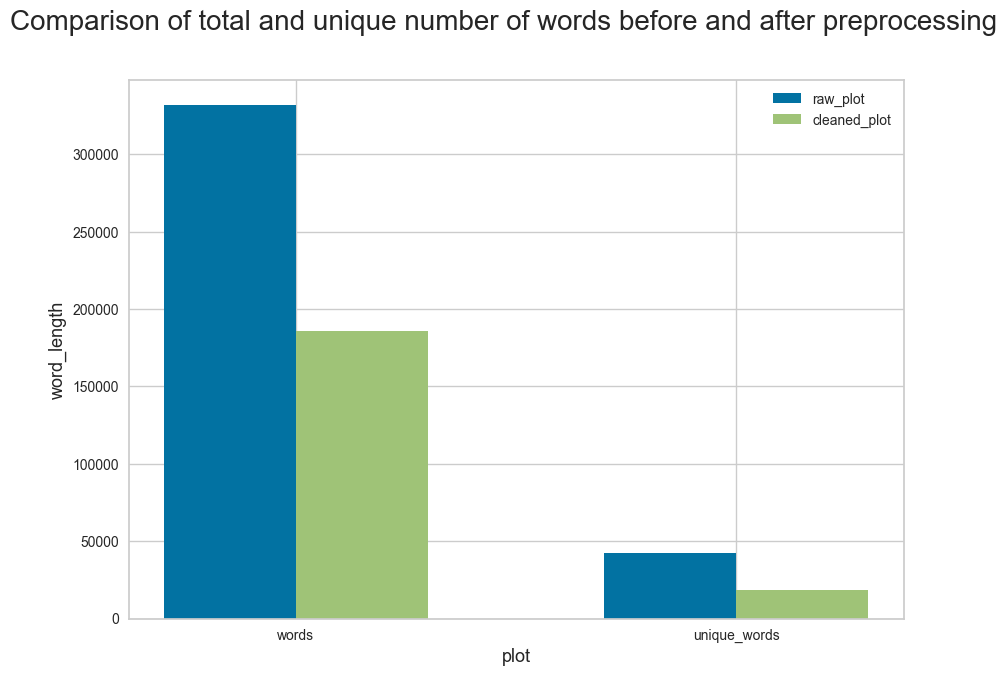

In [21]:
# Compare before and after
plot_length = [[raw_length, clean_length], [raw_unique_length, clean_unique_length]]
length_df = pd.DataFrame(plot_length, columns = ['num_of_words', 'num_of_unique_words'])
length_df['index'] = ['raw_plot', 'cleaned_plot']

y1 = length_df['num_of_words']
y2 = length_df['num_of_unique_words']

plt.figure(figsize=(10,7))
ind = np.arange(2)

width = 0.3

# Plotting
plt.bar(ind, y1, width, label='raw_plot')
plt.bar(ind + width, y2, width, label='cleaned_plot')

plt.xlabel('plot', size = 13)
plt.ylabel('word_length', size = 13)
plt.suptitle('Comparison of total and unique number of words before and after preprocessing', size = 20)
plt.xticks(ind + width / 2, ('words', 'unique_words'))
plt.legend(loc='best')
plt.show()

In [22]:
length_df

,num_of_words,num_of_unique_words,index
0,331694,186010,raw_plot
1,42201,18371,cleaned_plot


### Distribution of words in each genre


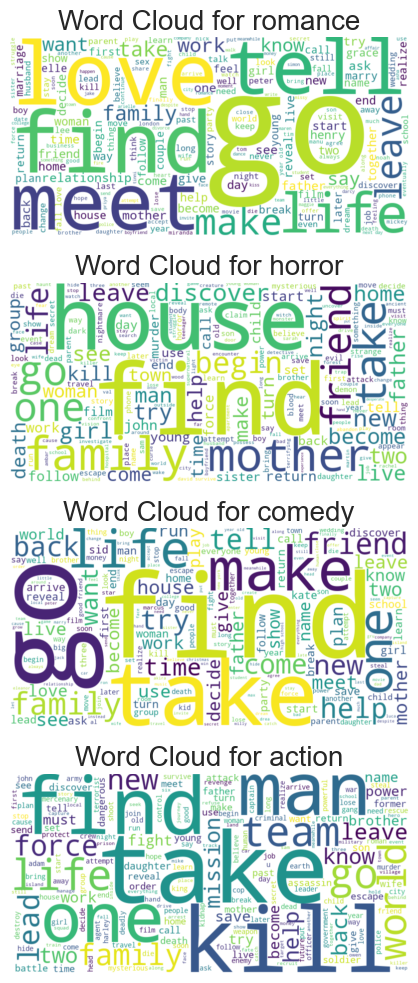

In [23]:
# Create a WordCloud for each genre
genres = new_movies['genre'].unique()

plt.figure(figsize=(15, 10))
for idx, genre in enumerate(genres):
    genre_text = ' '.join(new_movies[new_movies['genre'] == genre]['description'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(genre_text)
    
    plt.subplot(len(genres), 1, idx + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {genre}', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

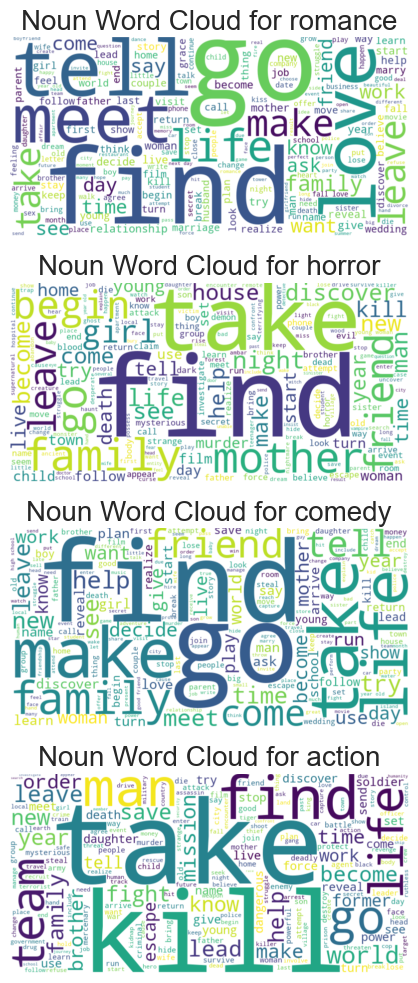

In [24]:
# Function to extract nouns from text
def extract_nouns_adj_verb(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB']])

# Create a WordCloud for each genre with only nouns
plt.figure(figsize=(15, 10))
for idx, genre in enumerate(genres):
    genre_text = ' '.join(new_movies[new_movies['genre'] == genre]['description'])
    noun_text = extract_nouns_adj_verb(genre_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(noun_text)
    
    plt.subplot(len(genres), 1, idx + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Noun Word Cloud for {genre}', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Modelling

### Assigning Independent and Target Variables and performing train test split into training and testing set

In [64]:
X = new_movies['description']
y = new_movies['labels']

vectorizer = TfidfVectorizer(ngram_range = (1,3), max_df=.85, min_df=15, lowercase=True)
tfidf_X = vectorizer.fit_transform(X)

print(tfidf_X)

X_train, X_test, y_train, y_test = train_test_split(tfidf_X, y, test_size= 0.29, random_state = 42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  (0, 784)	0.01303406844464007
  (0, 550)	0.021043265409924357
  (0, 297)	0.02712284324820921
  (0, 673)	0.009918183197863554
  (0, 1233)	0.04516036119545627
  (0, 622)	0.17060583902651805
  (0, 1208)	0.02635214238690767
  (0, 1489)	0.024587139760171704
  (0, 1578)	0.012704442703561684
  (0, 813)	0.7062671921290341
  (0, 1132)	0.24611499846821025
  (0, 1621)	0.006533220655288321
  (0, 370)	0.03946330673202678
  (0, 596)	0.02303062080981478
  (0, 474)	0.012029408229905586
  (0, 605)	0.14362173239808163
  (0, 5)	0.010751082588494543
  (0, 1507)	0.013919582950366365
  (0, 823)	0.01218527015812708
  (0, 1230)	0.07322718646658373
  (0, 1561)	0.02416104378767169
  (0, 833)	0.14592599133471823
  (0, 344)	0.02696108595806895
  (0, 539)	0.03593729861731102
  (0, 26)	0.03564239511763933
  :	:
  (999, 1493)	0.07566933741260831
  (999, 412)	0.0531350074148306
  (999, 796)	0.15797696200872569
  (999, 137)	0.17599328313710058
  (999, 312)	0.0871910195058083
  (999, 505)	0.16200218199690758
  (999, 1

In [70]:
import os, pickle
file_path = os.path.join('Model', 'vectorizer.pickle')
with open(file_path, 'wb') as file:
    pickle.dump(vectorizer, file)


In [26]:
# First simple Model using Dummy Classifier
dummy_grid = {
    'strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant']
}
dummy = DummyClassifier( random_state = 42)
dummy_gs = GridSearchCV(dummy, param_grid = dummy_grid, cv = 10).fit(X_train, y_train)

print("GridSearch Accuraction: ", dummy_gs.best_score_)

# Evaluate the best model on the test set
y_pred = dummy_gs.best_estimator_.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

GridSearch Accuraction:  0.24366197183098595
Test Set Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        73
           2       0.25      1.00      0.40        72
           3       0.00      0.00      0.00        73
           4       0.00      0.00      0.00        72

    accuracy                           0.25       290
   macro avg       0.06      0.25      0.10       290
weighted avg       0.06      0.25      0.10       290



### Using TfidfVectorizer on the independent variable and testing out the Multinomial Naive Bayes Model, Logistic Regression Model and Ensemble Learning


*Multonimal Naive Bayes*

In [65]:
model_resultstfidf = {}
mnb_grid = {
    'alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'fit_prior' : [True, False],
    'class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}
mnb = MultinomialNB()
mnb_tfidf_gs = GridSearchCV(mnb, param_grid = mnb_grid, cv = 10)
mnb_tfidf_gs.fit(X_train, y_train)
print("GridSearch Accuraction: ", mnb_tfidf_gs.best_score_)

# Evaluate the best model on the test set
y_pred = mnb_tfidf_gs.best_estimator_.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

GridSearch Accuraction:  0.6901408450704225
Test Set Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.73      0.72        73
           2       0.81      0.81      0.81        72
           3       0.63      0.64      0.64        73
           4       0.87      0.82      0.84        72

    accuracy                           0.75       290
   macro avg       0.75      0.75      0.75       290
weighted avg       0.75      0.75      0.75       290



*Logistic Regression*

In [66]:
lr_grid = {
    'penalty' : ['l1', 'l2', 'none'],
    'C' : [1.0, 1e2, 1e4, 1e10],
    'class_weight' : ['balanced', None],
    'solver' : ['lbfgs', 'liblinear'],
    'multi_class' : ['ovr', 'multinomial']
}
logreg = LogisticRegression(random_state = 42)
logreg_tfidf_gs = GridSearchCV(logreg, param_grid = lr_grid, cv = 10)
logreg_tfidf_gs.fit(X_train, y_train)
print("GridSearch Accuraction: ", logreg_tfidf_gs.best_score_)

# Evaluate the best model on the test set
y_pred = logreg_tfidf_gs.best_estimator_.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

GridSearch Accuraction:  0.6971830985915493
Test Set Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.70      0.69        73
           2       0.80      0.88      0.83        72
           3       0.64      0.60      0.62        73
           4       0.90      0.85      0.87        72

    accuracy                           0.76       290
   macro avg       0.76      0.76      0.75       290
weighted avg       0.75      0.76      0.75       290



In [69]:
logreg_best_model = LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=42, solver='liblinear').fit(X_train, y_train)

file_path = os.path.join('Model', 'LogisticRegression.pickle')
with open(file_path, 'wb') as file:
    pickle.dump(logreg_best_model, file)


*Ensemble Learning (Except SVM)*

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [30]:
from sklearn.svm import SVC

# Define parameter grids for each model
param_grids = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [1, 2, 5, 10],
        'min_samples_split': [2, 5, 10, 20]  # Note: min_samples_split cannot be 1
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10, 20]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1, 10],
        'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10, 20]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

# Define the models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Function to perform GridSearchCV
def run_grid_search(model_name, model, param_grid):
    print(f"Running GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(f"GridSearch Accuracy for {model_name}: {grid_search.best_score_}")

    # Evaluate the best model on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    print(f"Test Set Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

__Run GridSearchCV for each model separately__

In [31]:
# Decision Tree
run_grid_search('Decision Tree', models['Decision Tree'], param_grids['Decision Tree'])

Running GridSearchCV for Decision Tree...
GridSearch Accuracy for Decision Tree: 0.5154929577464789
Test Set Classification Report for Decision Tree:
              precision    recall  f1-score   support

           1       0.61      0.52      0.56        73
           2       0.53      0.58      0.56        72
           3       0.43      0.55      0.48        73
           4       0.51      0.39      0.44        72

    accuracy                           0.51       290
   macro avg       0.52      0.51      0.51       290
weighted avg       0.52      0.51      0.51       290



In [32]:
# Random Forest
run_grid_search('Random Forest', models['Random Forest'], param_grids['Random Forest'])

Running GridSearchCV for Random Forest...
GridSearch Accuracy for Random Forest: 0.7126760563380282
Test Set Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       0.62      0.75      0.68        73
           2       0.74      0.75      0.74        72
           3       0.62      0.55      0.58        73
           4       0.86      0.75      0.80        72

    accuracy                           0.70       290
   macro avg       0.71      0.70      0.70       290
weighted avg       0.71      0.70      0.70       290



In [33]:
# AdaBoost
run_grid_search('AdaBoost', models['AdaBoost'], param_grids['AdaBoost'])

Running GridSearchCV for AdaBoost...
GridSearch Accuracy for AdaBoost: 0.5816901408450704
Test Set Classification Report for AdaBoost:
              precision    recall  f1-score   support

           1       0.68      0.70      0.69        73
           2       0.74      0.51      0.61        72
           3       0.40      0.63      0.49        73
           4       0.71      0.49      0.58        72

    accuracy                           0.58       290
   macro avg       0.63      0.58      0.59       290
weighted avg       0.63      0.58      0.59       290



In [34]:
# SVM
run_grid_search('SVM', models['SVM'], param_grids['SVM'])

Running GridSearchCV for SVM...
GridSearch Accuracy for SVM: 0.6887323943661972
Test Set Classification Report for SVM:
              precision    recall  f1-score   support

           1       0.71      0.64      0.68        73
           2       0.79      0.85      0.82        72
           3       0.60      0.67      0.64        73
           4       0.89      0.82      0.86        72

    accuracy                           0.74       290
   macro avg       0.75      0.75      0.75       290
weighted avg       0.75      0.74      0.75       290



In [35]:
# Extra Trees
run_grid_search('Extra Trees', models['Extra Trees'], param_grids['Extra Trees'])

Running GridSearchCV for Extra Trees...
GridSearch Accuracy for Extra Trees: 0.7309859154929577
Test Set Classification Report for Extra Trees:
              precision    recall  f1-score   support

           1       0.64      0.64      0.64        73
           2       0.81      0.81      0.81        72
           3       0.59      0.60      0.59        73
           4       0.84      0.82      0.83        72

    accuracy                           0.72       290
   macro avg       0.72      0.72      0.72       290
weighted avg       0.72      0.72      0.72       290



### Deep Learning

#### *LSTM*

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam

In [37]:
X = new_movies['description']
y = new_movies['labels']

# Tokenisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [38]:
# Padding urutan
max_sequence_length = 100  # Sesuaikan dengan data Anda
X = pad_sequences(sequences, maxlen=max_sequence_length)

In [39]:
onehot_encoder = OneHotEncoder(sparse_output=False)
y = y.values.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

In [40]:
# Membagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42, stratify=y)

In [41]:
# Define hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 10
lstm_units= 100
dropout_rate = 0.2
embedding_dim = 128

# Define and compile the model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(lstm_units))
model.add(Dropout(dropout_rate))
model.add(Dense(4, activation='softmax'))  # 4 neurons for 4 classes
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict classes for test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to original labels
y_test_classes = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(y_test_classes, y_pred_classes))

Epoch 1/10
13/13 [==============================] - 6s 254ms/step - loss: 1.3854 - accuracy: 0.2590 - val_loss: 1.3780 - val_accuracy: 0.4545
Epoch 2/10
13/13 [==============================] - 3s 197ms/step - loss: 1.2779 - accuracy: 0.7064 - val_loss: 1.3292 - val_accuracy: 0.4364
Epoch 3/10
13/13 [==============================] - 3s 202ms/step - loss: 0.5324 - accuracy: 0.8256 - val_loss: 0.9150 - val_accuracy: 0.6318
Epoch 4/10
13/13 [==============================] - 3s 199ms/step - loss: 0.1430 - accuracy: 0.9641 - val_loss: 1.1333 - val_accuracy: 0.6091
Epoch 5/10
13/13 [==============================] - 3s 198ms/step - loss: 0.0333 - accuracy: 0.9949 - val_loss: 1.2937 - val_accuracy: 0.6045
Epoch 6/10
13/13 [==============================] - 3s 204ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 1.2585 - val_accuracy: 0.6318
Epoch 7/10
13/13 [==============================] - 3s 196ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.3800 - val_accuracy: 0.6364
Epoch 

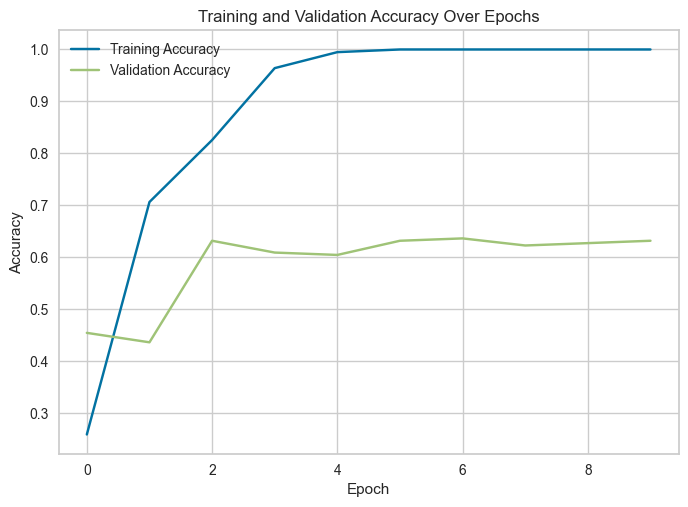

In [42]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()

#### *BERT*

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt

In [49]:
X = new_movies['description']
y = new_movies['labels'].tolist()

# Map labels to zero-indexed format
label_mapping = {1: 0, 2: 1, 3: 2, 4: 3}
y = [label_mapping[label] for label in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29, random_state=42, stratify=y)

In [50]:
def encode_data(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, 0)
    attention_masks = tf.concat(attention_masks, 0)
    
    return input_ids, attention_masks

In [46]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y)))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
45/45 [==============================] - 464s 10s/step - loss: 0.3232 - accuracy: 0.8915 - val_loss: 0.7355 - val_accuracy: 0.7172
Epoch 2/5
45/45 [==============================] - 394s 9s/step - loss: 0.1704 - accuracy: 0.9507 - val_loss: 0.7601 - val_accuracy: 0.7448
Epoch 3/5
45/45 [==============================] - 394s 9s/step - loss: 0.1040 - accuracy: 0.9690 - val_loss: 0.8453 - val_accuracy: 0.7379
Epoch 4/5
45/45 [==============================] - 395s 9s/step - loss: 0.0304 - accuracy: 0.9958 - val_loss: 1.0124 - val_accuracy: 0.7379
Epoch 5/5
19/19 [==============================] - 47s 2s/step - loss: 0.9975 - accuracy: 0.7621
Loss: 0.9974950551986694, Accuracy: 0.7620689868927002


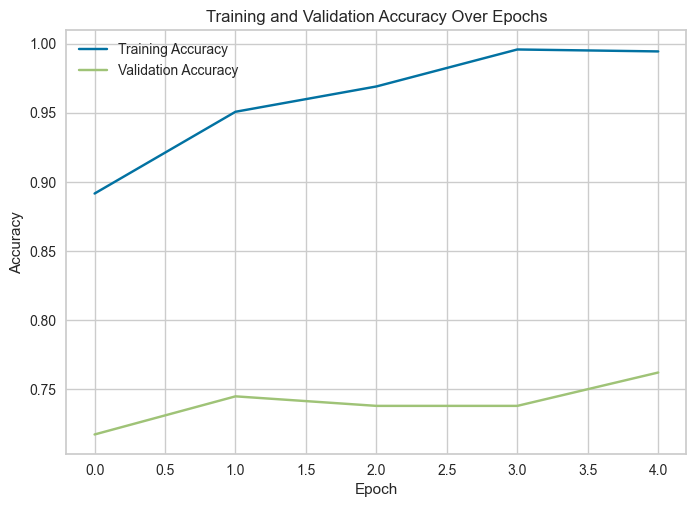

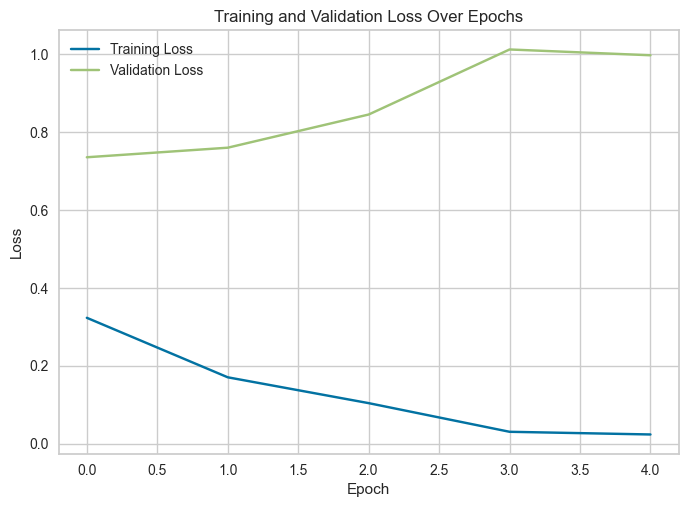

19/19 [==============================] - 48s 2s/step


In [53]:
max_length = 128  # Define maximum sequence length
X_train_ids, X_train_masks = encode_data(X_train, tokenizer, max_length)
X_test_ids, X_test_masks = encode_data(X_test, tokenizer, max_length)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': X_train_ids, 'attention_mask': X_train_masks}, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': X_test_ids, 'attention_mask': X_test_masks}, y_test))

# Batch and shuffle datasets
batch_size = 16
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Predict classes for test set
y_pred = model.predict(test_dataset).logits
y_pred_classes = np.argmax(y_pred, axis=1)

In [54]:
# Generate classification report
print(classification_report(y_test, y_pred_classes, target_names=['Romance', 'Horror', 'Comedy', 'Action']))

              precision    recall  f1-score   support

     Romance       0.67      0.79      0.72        73
      Horror       0.79      0.85      0.82        72
      Comedy       0.76      0.52      0.62        73
      Action       0.84      0.89      0.86        72

    accuracy                           0.76       290
   macro avg       0.77      0.76      0.76       290
weighted avg       0.76      0.76      0.76       290



In [72]:
from transformers import TFBertForSequenceClassification

# Save the model
model.save_pretrained('Model/BERTmodel')

# Load the model
model = TFBertForSequenceClassification.from_pretrained('Model/BERTmodel')

Some layers from the model checkpoint at Model/BERTmodel were not used when initializing TFBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at Model/BERTmodel.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
